In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
df = pd.read_csv('/content/Movie dataset.csv', encoding='latin1')
print(df)

                                     Name    Year Duration            Genre  \
0                                             NaN      NaN            Drama   
1      #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                             #Homecoming  (2021)   90 min   Drama, Musical   
3                                 #Yaaram  (2019)  110 min  Comedy, Romance   
4                       ...And Once Again  (2010)  105 min            Drama   
...                                   ...     ...      ...              ...   
15504                 Zulm Ko Jala Doonga  (1988)      NaN           Action   
15505                               Zulmi  (1999)  129 min    Action, Drama   
15506                           Zulmi Raj  (2005)      NaN           Action   
15507                       Zulmi Shikari  (1988)      NaN           Action   
15508                        Zulm-O-Sitam  (1998)  130 min    Action, Drama   

       Rating Votes            Director           A

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB
None


In [ ]:
print(df.describe())

            Rating
count  7919.000000
mean      5.841621
std       1.381777
min       1.100000
25%       4.900000
50%       6.000000
75%       6.800000
max      10.000000


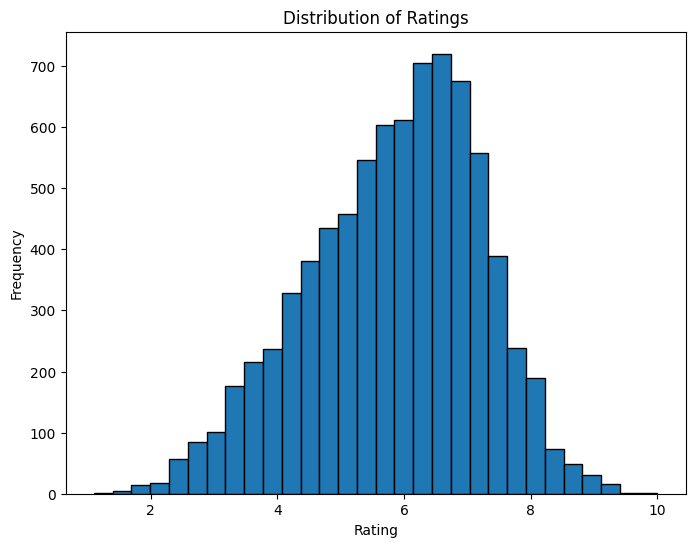

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['Rating'].dropna(), bins=30, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

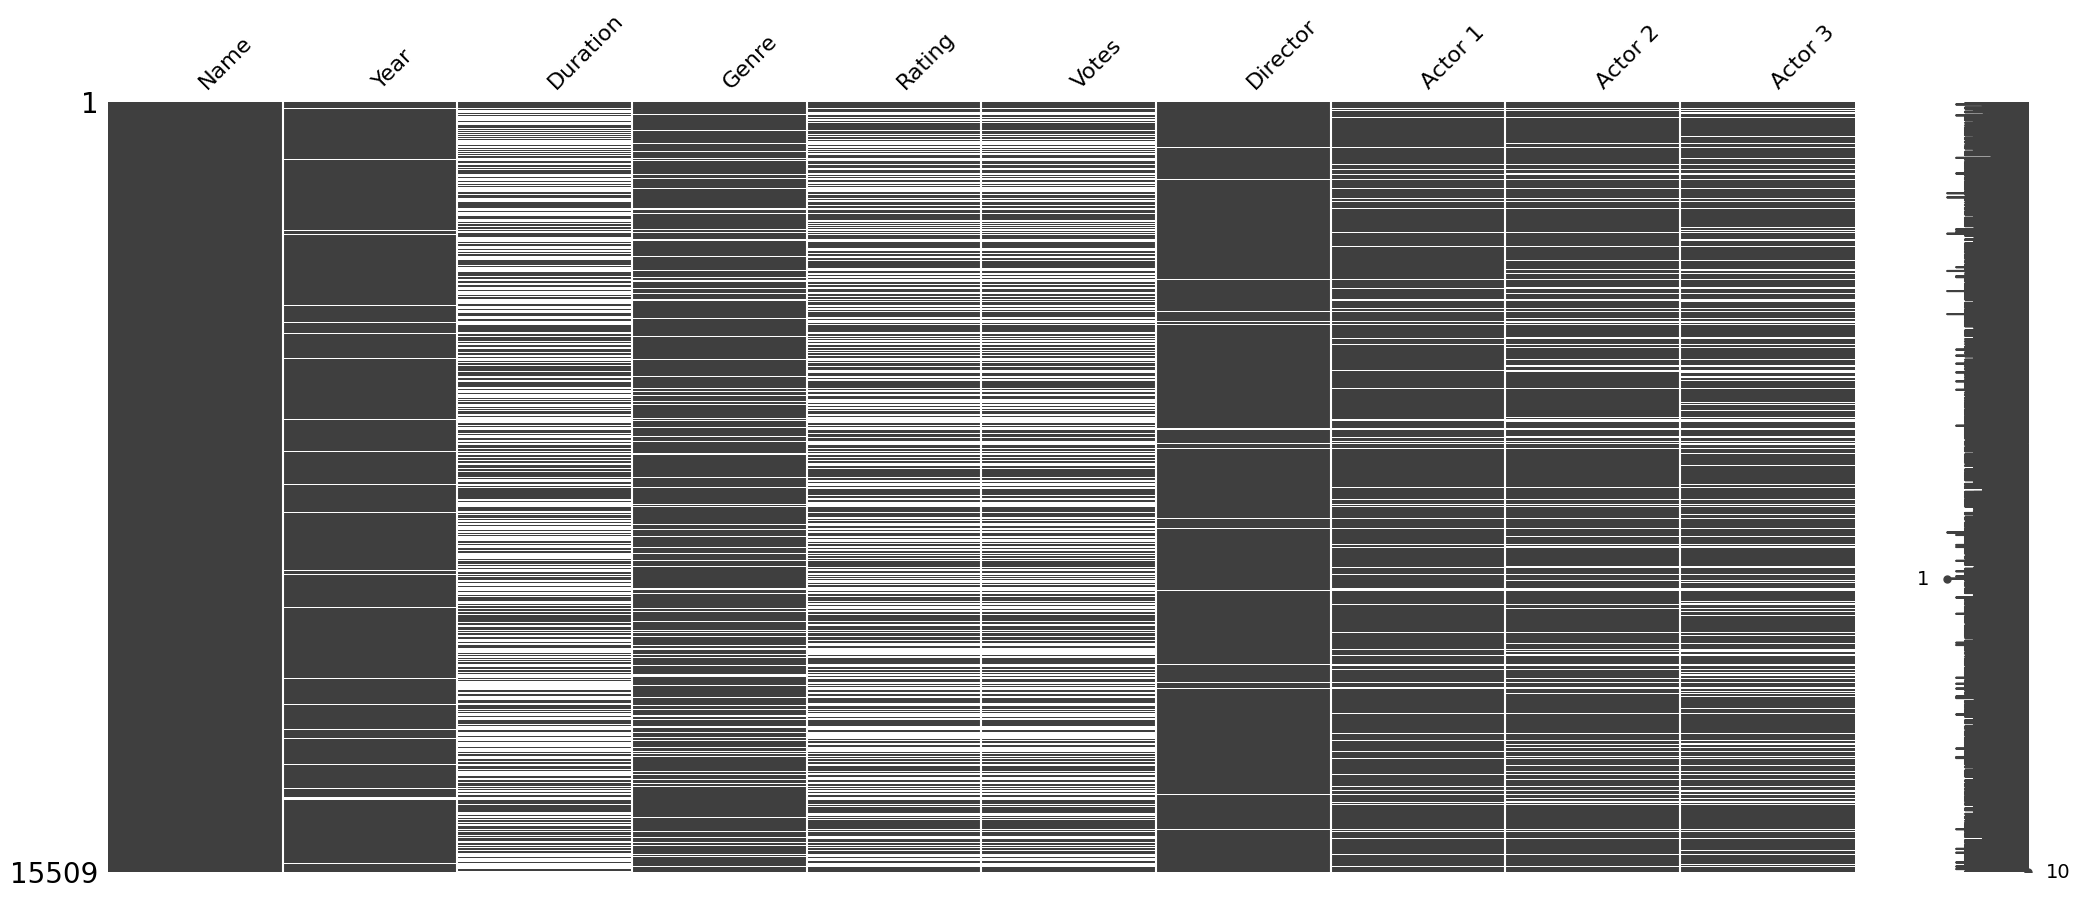

In [ ]:
import missingno as msno
msno.matrix(df)
plt.show()

In [ ]:
df = df.dropna(subset=['Rating'])
df.loc[:, 'Genre'] = df['Genre'].fillna('Unknown')
df.loc[:, 'Director'] = df['Director'].fillna('Unknown')
df.loc[:, 'Actor 1'] = df['Actor 1'].fillna('Unknown')
df.loc[:, 'Actor 2'] = df['Actor 2'].fillna('Unknown')
df.loc[:, 'Actor 3'] = df['Actor 3'].fillna('Unknown')
df = df.drop(columns=['Name', 'Year', 'Votes'])
df['Duration'] = df['Duration'].str.replace(' min', '').astype(float)
X = df.drop(columns=['Rating'])
y = df['Rating']

In [ ]:
categorical_features = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
numeric_features = ['Duration']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_dist = {
    'model__n_estimators': [100],
    'model__max_depth': [10]
}
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(random_state=42))])
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=1,
                                      scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
randomized_search.fit(X_train, y_train)
print(f'Best parameters found: {randomized_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'model__n_estimators': 100, 'model__max_depth': 10}


In [ ]:
best_model = randomized_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (Random Forest): {mse}')
print(f'R-squared (Random Forest): {r2}')

Mean Squared Error (Random Forest): 1.6415556487026375
R-squared (Random Forest): 0.11703738841212696


In [ ]:
feature_names = numeric_features + \
                list(best_model.named_steps['preprocessor'].named_transformers_['cat']
                     .named_steps['onehot'].get_feature_names_out(categorical_features))
importances = best_model.named_steps['model'].feature_importances_
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = feature_importances.nlargest(10, 'Importance')

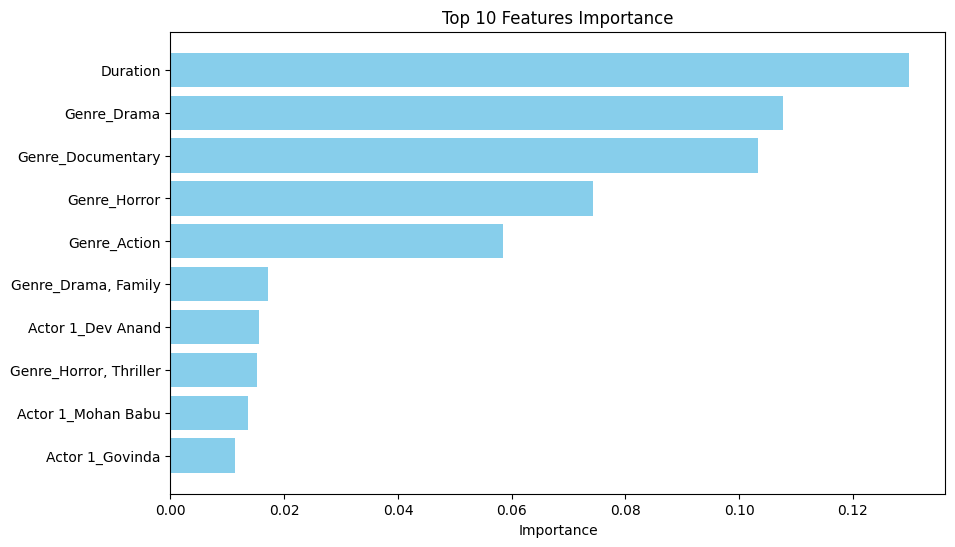

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features Importance')
plt.gca().invert_yaxis()
plt.show()

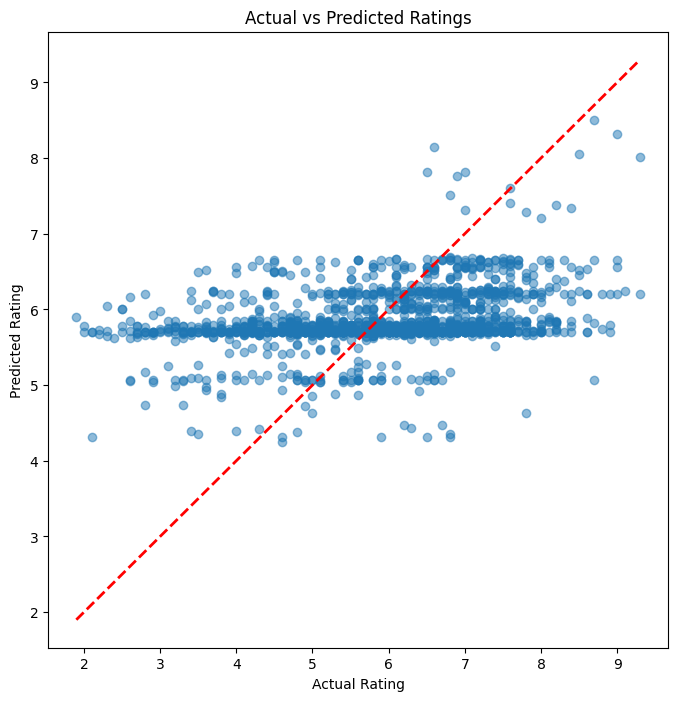

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.show()

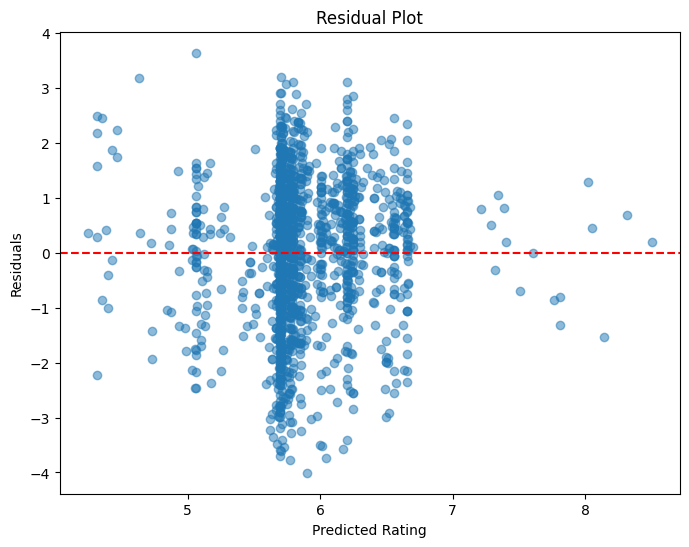

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Rating')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()